# Animal Detection Tutorial

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/georgia-tech-db/license-plate-recognition/blob/main/README.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" /> Run on Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/georgia-tech-db/license-plate-recognition/blob/main/README.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" /> View source on GitHub</a>
  </td>
  <td>
    <a target="_blank" href="
    https://raw.githubusercontent.com/georgia-tech-db/license-plate-recognition/main/README.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" /> Download notebook</a>
  </td>
</table>
<br>
<br>

### Install Application Dependecies 

In [1]:
!wget -nc https://raw.githubusercontent.com/georgia-tech-db/license-plate-recognition/main/requirements.txt
!pip -q --no-color install -r requirements.txt

File 'requirements.txt' already there; not retrieving.



### Start EVA server

We are reusing the start server notebook for launching the EVA server.

In [2]:
!wget -nc "https://raw.githubusercontent.com/georgia-tech-db/eva/master/tutorials/00-start-eva-server.ipynb"
%run 00-start-eva-server.ipynb
cursor = connect_to_server()

--2023-01-14 22:00:13--  https://raw.githubusercontent.com/georgia-tech-db/eva/master/tutorials/00-start-eva-server.ipynb
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3970 (3.9K) [text/plain]
Saving to: '00-start-eva-server.ipynb'

00-start-eva-server 100%[===================>]   3.88K  --.-KB/s    in 0s      

2023-01-14 22:00:13 (25.6 MB/s) - '00-start-eva-server.ipynb' saved [3970/3970]

nohup eva_server > eva.log 2>&1 &
Note: you may need to restart the kernel to use updated packages.


### Register Animal Detection UDF

In [57]:
cursor.execute("DROP UDF AnimalImageClassifier;")
response = cursor.fetch_all()
print(response)
cursor.execute("""CREATE UDF IF NOT EXISTS AnimalImageClassifier
      INPUT  (frame NDARRAY UINT8(3, ANYDIM, ANYDIM))
      OUTPUT (labels NDARRAY STR(ANYDIM), 
              scores NDARRAY FLOAT32(ANYDIM))
      TYPE  Classification
      IMPL  'animal_image_classifier.py';
      """)
response = cursor.fetch_all()
print(response)

@status: ResponseStatus.SUCCESS
@batch: 
                                                 0
0  UDF AnimalImageClassifier successfully dropped
@query_time: 0.014918280998244882
@status: ResponseStatus.SUCCESS
@batch: 
                                                                0
0  UDF AnimalImageClassifier successfully added to the database.
@query_time: 0.7051594499498606


## Download Images

In [58]:
!wget -nc "https://raw.githubusercontent.com/georgia-tech-db/license-plate-recognition/main/test_image_1.png"

# DOWNLOAD ADDITIONAL IMAGES IF NEEDED AND LOAD THEM
!tail -n 50 eva.log

cursor.execute('DROP TABLE IF EXISTS MyImages')
response = cursor.fetch_all()
print(response)

file_name = "dog.jpg"
cursor.execute('LOAD IMAGE "' + file_name + '" INTO MyImages;')
response = cursor.fetch_all()
print(response)

cursor.execute("""SELECT AnimalImageClassifier(data)
                FROM MyImages""")
response = cursor.fetch_all()
print(response)

File 'test_image_1.png' already there; not retrieving.

14
9.385511e-05
15
0.00036656298
16
0.00095979724
17
0.003810441
18
0.0081961155
19
0.0054705353
20
0.0017279587
21
1.0414637e-06
22
0.0030375305
23
1.737835e-05
24
0.014851449
25
0.015330793
26
0.0015242863
27
0.002966282
28
0.0018485035
29
0.035201613
30
0.004002764
31
0.0016468045
01-14-2023 22:36:23 INFO  [timer:timer.py:log_elapsed_time:0045] Query Response Time: 1.1696 sec
01-14-2023 22:37:59 INFO  [timer:timer.py:log_elapsed_time:0045] Query Compile Time: 0.0026 sec
01-14-2023 22:37:59 INFO  [timer:timer.py:log_elapsed_time:0045] Query Response Time: 0.0276 sec
01-14-2023 22:38:00 INFO  [timer:timer.py:log_elapsed_time:0045] Query Compile Time: 0.0042 sec
01-14-2023 22:38:00 INFO  [timer:timer.py:log_elapsed_time:0045] Query Response Time: 0.0554 sec
01-14-2023 22:38:00 INFO  [timer:timer.py:log_elapsed_time:0045] Query Compile Time: 0.0336 sec
01-14-2023 22:38:00 INFO  [animal_image_classifier:animal_image_classifier.py:en

### Annotate Model Output on Image

In [56]:
import cv2
from pprint import pprint
from matplotlib import pyplot as plt
from pathlib import Path

def annotate_image_ocr(detections, input_image_path, frame_id):
    color1=(0, 255, 150)
    color2=(255, 49, 49)
    white=(255, 255, 255)
    thickness=4

    frame = cv2.imread(input_image_path)
    height, width = frame.shape[:2]

    if frame_id == 0:
        frame= cv2.copyMakeBorder(frame, 0, 100, 0, 100, cv2.BORDER_CONSTANT,value=white)

    print(detections)
    plate_id = 0

    df = detections
    df = df[['animalimageclassifier.labels']][df.index == frame_id]

    x_offset = width * 0.2
    y_offset = height * 0.4

    if df.size:
        dfLst = df.values.tolist()
        for label in dfLst[0][0]:

            cv2.putText(frame, label, (int(x_offset), int(y_offset)), cv2.FONT_HERSHEY_SIMPLEX, 3, color2, thickness, cv2.LINE_AA) 
            y_offset = y_offset + height * 0.2

            # Show every  frame
            plt.imshow(frame)
            plt.show()

            p = Path(input_image_path)
            output_path = "{0}_{2}{1}".format(p.stem, p.suffix, "output")

            cv2.imwrite(output_path, frame)


         animalimageclassifier.labels          animalimageclassifier.scores
0  [antelope_duiker, blank, elephant]  [0.11086655, 0.40322393, 0.10351932]


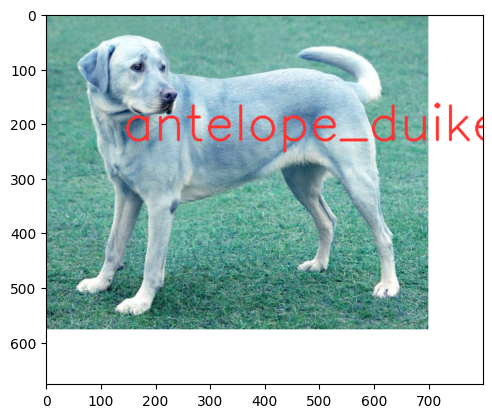

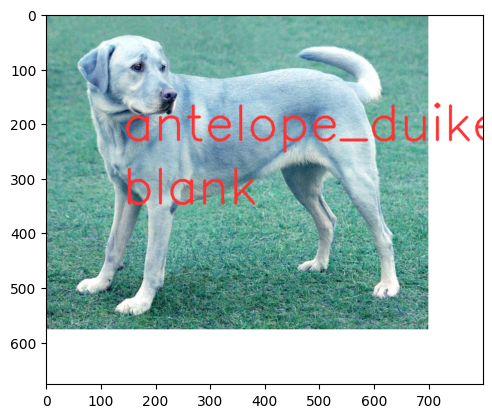

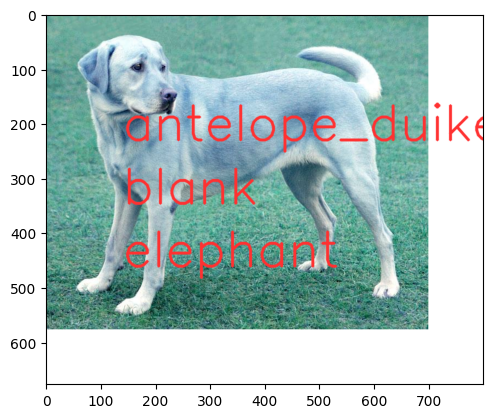

In [54]:
dataframe = response.batch.frames
annotate_image_ocr(dataframe, 'dog.jpg', frame_id = 0)